In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import pmdarima as pm

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
  file_path = '/content/drive/My Drive/Synthetic_data_with_OEE_MME_16_06_24.csv'

In [ ]:
# Load the dataset into a pandas dataframe
data = pd.read_csv(file_path)

In [ ]:
# Extract dates before dropping the 'Date' column
dates = data['Date']
data = data.drop(columns=['Date'])

In [ ]:
# Split data into features (X) and targets (y)
X = data.drop(columns=['OEE', 'MME'])
y = data[['OEE', 'MME']]

In [ ]:
# Normalize the feature data
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# Normalize the target data
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)


In [ ]:
# Split into training and testing sets
X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(X_scaled, y_scaled, dates, test_size=0.2, random_state=42)


In [ ]:
# Function to create sequences for the GRU model
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps + 1):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps - 1])
    return np.array(Xs), np.array(ys)

In [ ]:
time_steps = 5
X_train_seq, y_train_seq = create_sequences(X_train, y_train, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, time_steps)

In [ ]:
# Adjust dates for sequences
def adjust_dates(dates, time_steps):
    return dates[time_steps-1:]

In [ ]:
dates_train_seq = adjust_dates(dates_train.values, time_steps)
dates_test_seq = adjust_dates(dates_test.values, time_steps)

In [ ]:
# Verify the lengths to ensure they match
print(f'X_train_seq shape: {X_train_seq.shape}, y_train_seq shape: {y_train_seq.shape}')
print(f'X_test_seq shape: {X_test_seq.shape}, y_test_seq shape: {y_test_seq.shape}')
print(f'dates_train_seq length: {len(dates_train_seq)}, dates_test_seq length: {len(dates_test_seq)}')

X_train_seq shape: (433, 5, 13), y_train_seq shape: (433, 2)
X_test_seq shape: (106, 5, 13), y_test_seq shape: (106, 2)
dates_train_seq length: 433, dates_test_seq length: 106


In [ ]:
# Define the GRU model with separate outputs for OEE and MME
input_layer = Input(shape=(time_steps, X_train_seq.shape[2]))
gru_layer = GRU(64, return_sequences=True)(input_layer)
gru_layer = GRU(32)(gru_layer)

# Output layers for OEE and MME
output_oee = Dense(1, name='oee_output')(gru_layer)
output_mme = Dense(1, name='mme_output')(gru_layer)

In [ ]:
model = Model(inputs=input_layer, outputs=[output_oee, output_mme])

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mse')

In [ ]:
# Train the model
history = model.fit(
    X_train_seq,
    {'oee_output': y_train_seq[:, 0], 'mme_output': y_train_seq[:, 1]},
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)


Epoch 1/50
11/11 [==============================] - 7s 109ms/step - loss: 1.7586 - oee_output_loss: 0.8731 - mme_output_loss: 0.8856 - val_loss: 1.6818 - val_oee_output_loss: 0.7341 - val_mme_output_loss: 0.9477
Epoch 2/50
11/11 [==============================] - 0s 13ms/step - loss: 1.4144 - oee_output_loss: 0.6476 - mme_output_loss: 0.7667 - val_loss: 1.4819 - val_oee_output_loss: 0.6075 - val_mme_output_loss: 0.8744
Epoch 3/50
11/11 [==============================] - 0s 14ms/step - loss: 1.1718 - oee_output_loss: 0.5065 - mme_output_loss: 0.6653 - val_loss: 1.2501 - val_oee_output_loss: 0.4599 - val_mme_output_loss: 0.7902
Epoch 4/50
11/11 [==============================] - 0s 14ms/step - loss: 0.9222 - oee_output_loss: 0.3620 - mme_output_loss: 0.5603 - val_loss: 0.9896 - val_oee_output_loss: 0.3053 - val_mme_output_loss: 0.6843
Epoch 5/50
11/11 [==============================] - 0s 14ms/step - loss: 0.6868 - oee_output_loss: 0.2315 - mme_output_loss: 0.4553 - val_loss: 0.7250 - va

In [ ]:
# Evaluate the model
loss = model.evaluate(X_test_seq,
                      {'oee_output': y_test_seq[:, 0], 'mme_output': y_test_seq[:, 1]},
                      verbose=1)
print(f'Test loss: {loss}')

4/4 [==============================] - 0s 5ms/step - loss: 0.0257 - oee_output_loss: 0.0126 - mme_output_loss: 0.0131
Test loss: [0.025677403435111046, 0.012612425722181797, 0.013064978644251823]


In [ ]:
# Predict
y_pred_oee, y_pred_mme = model.predict(X_test_seq)

4/4 [==============================] - 1s 4ms/step


In [ ]:
# Inverse transform the predictions
y_pred_oee_inverse = scaler_y.inverse_transform(np.column_stack([y_pred_oee, np.zeros(y_pred_oee.shape)]))[:, 0]
y_pred_mme_inverse = scaler_y.inverse_transform(np.column_stack([np.zeros(y_pred_mme.shape), y_pred_mme]))[:, 1]

y_test_oee_inverse = scaler_y.inverse_transform(np.column_stack([y_test_seq[:, 0], np.zeros(y_test_seq[:, 0].shape)]))[:, 0]
y_test_mme_inverse = scaler_y.inverse_transform(np.column_stack([np.zeros(y_test_seq[:, 1].shape), y_test_seq[:, 1]]))[:, 1]


In [ ]:
# Custom function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [ ]:
# Calculate evaluation metrics for OEE
rmse_oee = np.sqrt(mean_squared_error(y_test_oee_inverse, y_pred_oee_inverse))
mae_oee = mean_absolute_error(y_test_oee_inverse, y_pred_oee_inverse)
mape_oee = mean_absolute_percentage_error(y_test_oee_inverse, y_pred_oee_inverse)

print(f'OEE - RMSE: {rmse_oee}')
print(f'OEE - MAE: {mae_oee}')
print(f'OEE - MAPE: {mape_oee}')

# Calculate evaluation metrics for MME
rmse_mme = np.sqrt(mean_squared_error(y_test_mme_inverse, y_pred_mme_inverse))
mae_mme = mean_absolute_error(y_test_mme_inverse, y_pred_mme_inverse)
mape_mme = mean_absolute_percentage_error(y_test_mme_inverse, y_pred_mme_inverse)

print(f'MME - RMSE: {rmse_mme}')
print(f'MME - MAE: {mae_mme}')
print(f'MME - MAPE: {mape_mme}')

OEE - RMSE: 0.008610822518241884
OEE - MAE: 0.006386744010500437
OEE - MAPE: 1.0278626390116705
MME - RMSE: 0.026975781809578443
MME - MAE: 0.021368916714216687
MME - MAPE: 1.6748796467303664


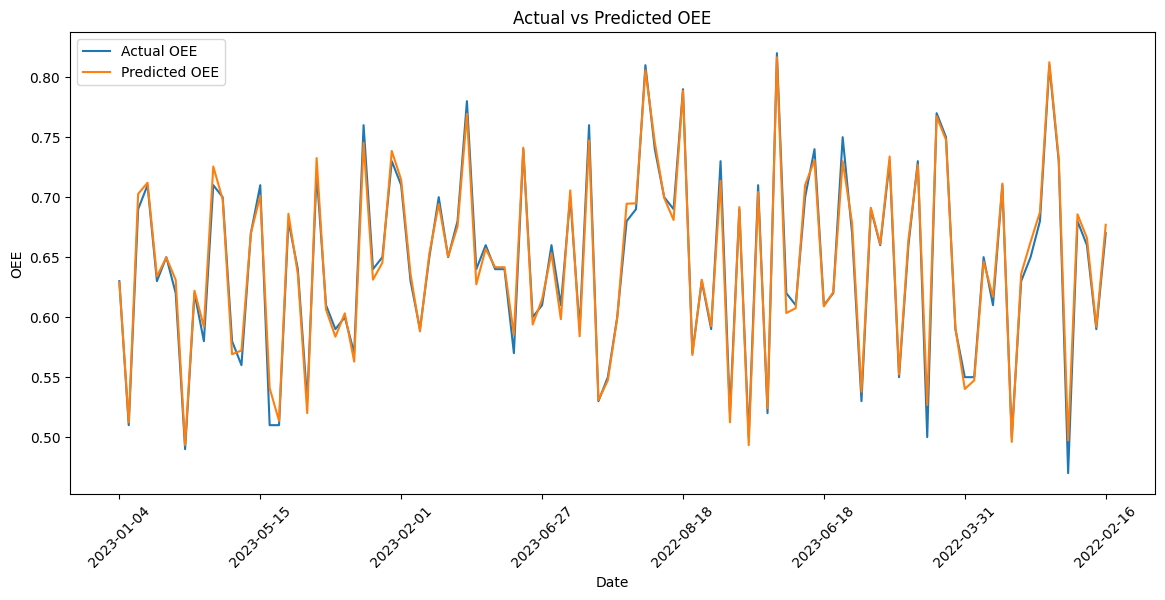

In [ ]:
# Plotting actual vs predicted values for OEE
plt.figure(figsize=(14, 6))
plt.plot(dates_test_seq, y_test_oee_inverse, label='Actual OEE')
plt.plot(dates_test_seq, y_pred_oee_inverse, label='Predicted OEE')
plt.title('Actual vs Predicted OEE')
plt.xlabel('Date')
plt.ylabel('OEE')
plt.legend()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(8))  # Added line
plt.show()


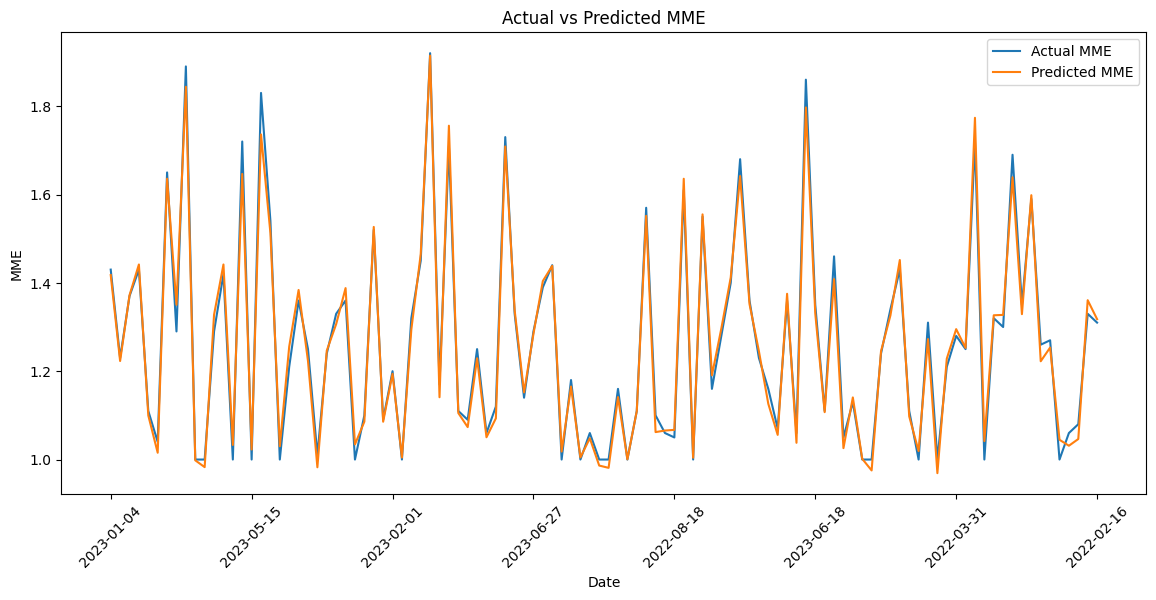

In [ ]:
# Plotting actual vs predicted values for MME
plt.figure(figsize=(14, 6))
plt.plot(dates_test_seq, y_test_mme_inverse, label='Actual MME')
plt.plot(dates_test_seq, y_pred_mme_inverse, label='Predicted MME')
plt.title('Actual vs Predicted MME')
plt.xlabel('Date')
plt.ylabel('MME')
plt.legend()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(8))  # Added line
plt.show()

### **ARIMA MODEL**

ADF Statistic: -17.544033062093174
p-value: 4.175005598720268e-30
Critical Values: 1% -3.442405720052601
Critical Values: 5% -2.866857804790472
Critical Values: 10% -2.5696022094099824
ADF Statistic: -22.413478408267764
p-value: 0.0
Critical Values: 1% -3.442383534871275
Critical Values: 5% -2.8668480382580386
Critical Values: 10% -2.569597004924258


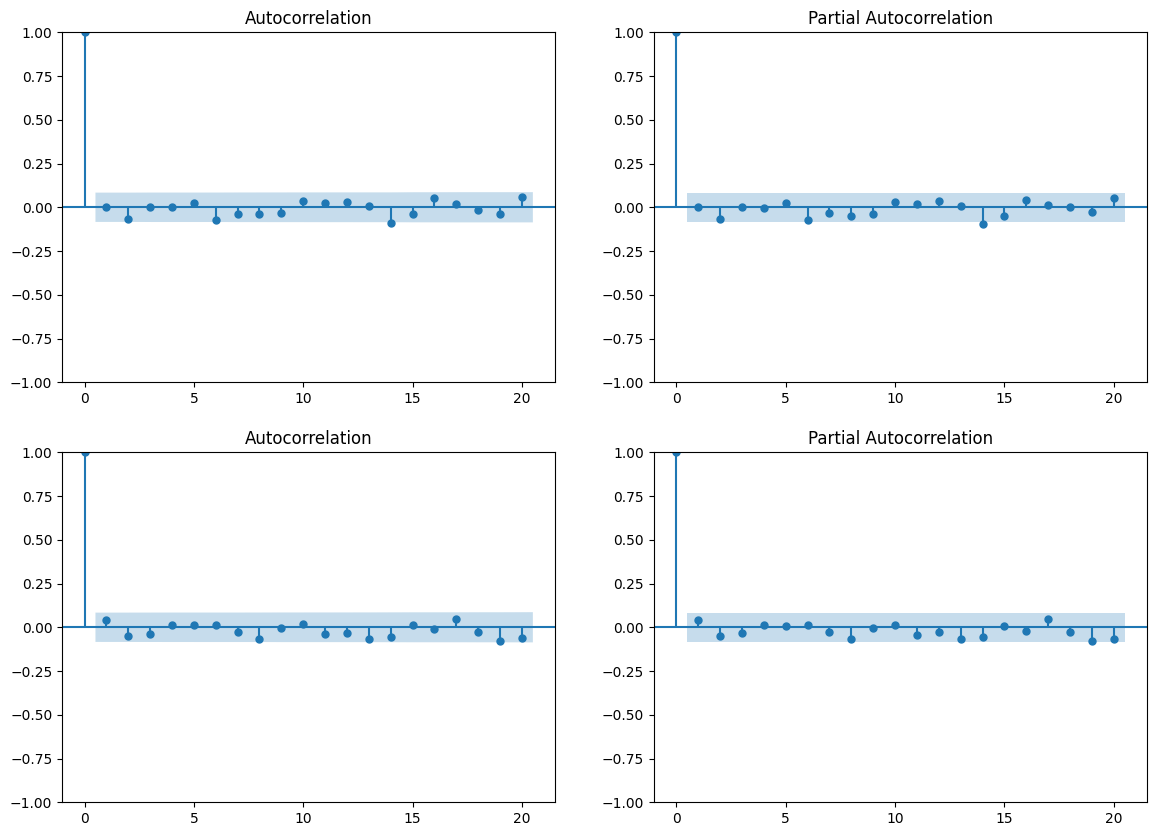

In [ ]:
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import pmdarima as pm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print('Critical Values:', key, value)
    return result[1] <= 0.05  # If p-value <= 0.05, the series is stationary

oee_stationary = check_stationarity(data['OEE'])
mme_stationary = check_stationarity(data['MME'])

if not oee_stationary:
    data['OEE_diff'] = data['OEE'].diff().dropna()
if not mme_stationary:
    data['MME_diff'] = data['MME'].diff().dropna()

# Plot ACF and PACF
fig, ax = plt.subplots(2, 2, figsize=(14, 10))
sm.graphics.tsa.plot_acf(data['OEE'].dropna(), lags=20, ax=ax[0, 0])
sm.graphics.tsa.plot_pacf(data['OEE'].dropna(), lags=20, ax=ax[0, 1])
sm.graphics.tsa.plot_acf(data['MME'].dropna(), lags=20, ax=ax[1, 0])
sm.graphics.tsa.plot_pacf(data['MME'].dropna(), lags=20, ax=ax[1, 1])
plt.show()



In [ ]:
# Fit ARIMA models using auto_arima
model_oee = pm.auto_arima(data['OEE_diff'].dropna() if 'OEE_diff' in data else data['OEE'], seasonal=False)
model_mme = pm.auto_arima(data['MME_diff'].dropna() if 'MME_diff' in data else data['MME'], seasonal=False)

# Make predictions
n_periods = int(len(data) * 0.2)
oee_forecast, oee_confint = model_oee.predict(n_periods=n_periods, return_conf_int=True)
mme_forecast, mme_confint = model_mme.predict(n_periods=n_periods, return_conf_int=True)

oee_forecast_dates = dates[int(len(data) * 0.8):int(len(data) * 0.8) + n_periods]
mme_forecast_dates = dates[int(len(data) * 0.8):int(len(data) * 0.8) + n_periods]


ARIMA OEE - RMSE: 0.07414640858918461
ARIMA OEE - MAE: 0.06015747617672872
ARIMA OEE - MAPE: nan
ARIMA MME - RMSE: 0.2562420997406556
ARIMA MME - MAE: 0.21116448350446462
ARIMA MME - MAPE: nan


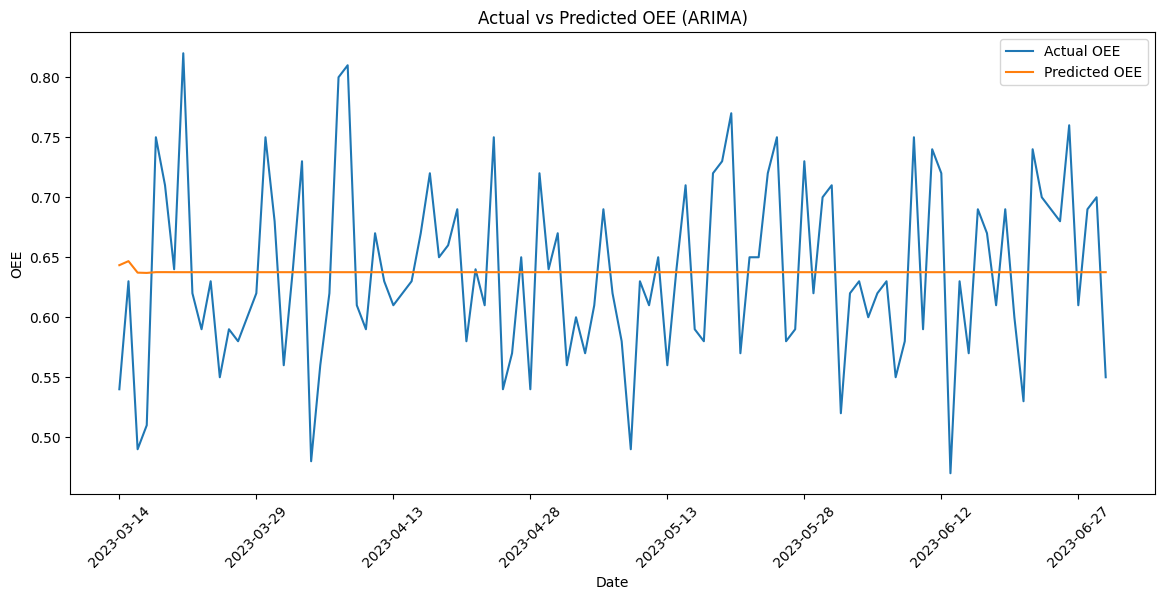

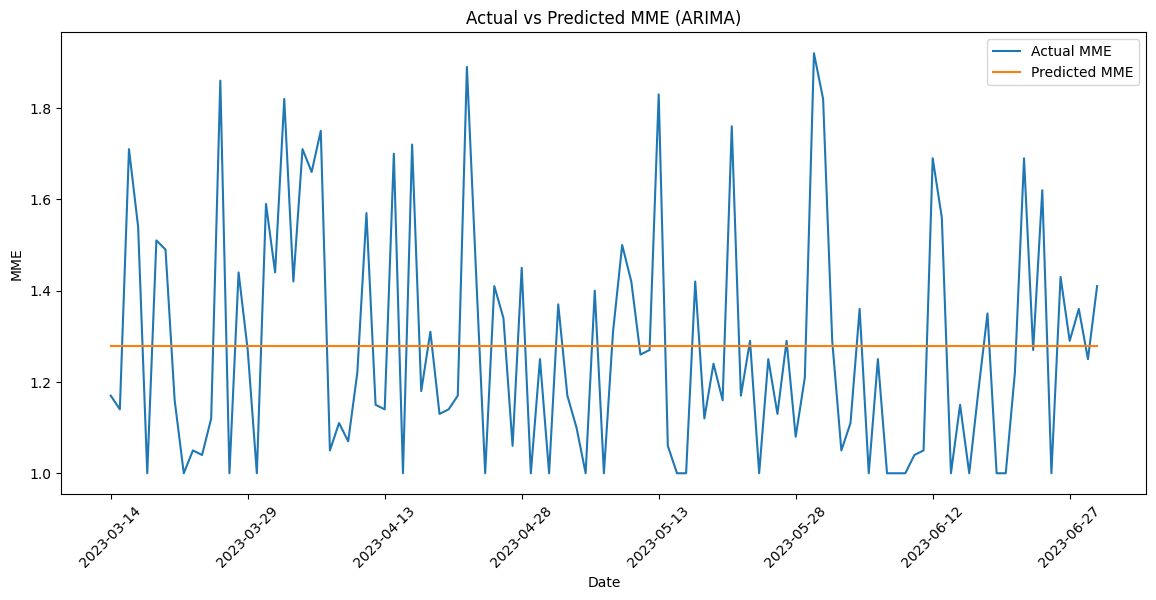

In [ ]:
# Calculate evaluation metrics
rmse_oee_arima = np.sqrt(mean_squared_error(data['OEE'][int(len(data) * 0.8):int(len(data) * 0.8) + n_periods], oee_forecast))
mae_oee_arima = mean_absolute_error(data['OEE'][int(len(data) * 0.8):int(len(data) * 0.8) + n_periods], oee_forecast)
mape_oee_arima = np.mean(np.abs((data['OEE'][int(len(data) * 0.8):int(len(data) * 0.8) + n_periods] - oee_forecast) / data['OEE'][int(len(data) * 0.8):int(len(data) * 0.8) + n_periods])) * 100

print(f'ARIMA OEE - RMSE: {rmse_oee_arima}')
print(f'ARIMA OEE - MAE: {mae_oee_arima}')
print(f'ARIMA OEE - MAPE: {mape_oee_arima}')

rmse_mme_arima = np.sqrt(mean_squared_error(data['MME'][int(len(data) * 0.8):int(len(data) * 0.8) + n_periods], mme_forecast))
mae_mme_arima = mean_absolute_error(data['MME'][int(len(data) * 0.8):int(len(data) * 0.8) + n_periods], mme_forecast)
mape_mme_arima = np.mean(np.abs((data['MME'][int(len(data) * 0.8):int(len(data) * 0.8) + n_periods] - mme_forecast) / data['MME'][int(len(data) * 0.8):int(len(data) * 0.8) + n_periods])) * 100

print(f'ARIMA MME - RMSE: {rmse_mme_arima}')
print(f'ARIMA MME - MAE: {mae_mme_arima}')
print(f'ARIMA MME - MAPE: {mape_mme_arima}')

# Plotting actual vs predicted values for ARIMA OEE
plt.figure(figsize=(14, 6))
plt.plot(oee_forecast_dates, data['OEE'][int(len(data) * 0.8):int(len(data) * 0.8) + n_periods], label='Actual OEE')
plt.plot(oee_forecast_dates, oee_forecast, label='Predicted OEE')
plt.title('Actual vs Predicted OEE (ARIMA)')
plt.xlabel('Date')
plt.ylabel('OEE')
plt.legend()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(8))  # Adjusted line for date ticks
plt.show()

# Plotting actual vs predicted values for ARIMA MME
plt.figure(figsize=(14, 6))
plt.plot(mme_forecast_dates, data['MME'][int(len(data) * 0.8):int(len(data) * 0.8) + n_periods], label='Actual MME')
plt.plot(mme_forecast_dates, mme_forecast, label='Predicted MME')
plt.title('Actual vs Predicted MME (ARIMA)')
plt.xlabel('Date')
plt.ylabel('MME')
plt.legend()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(8))  # Adjusted line for date ticks
plt.show()


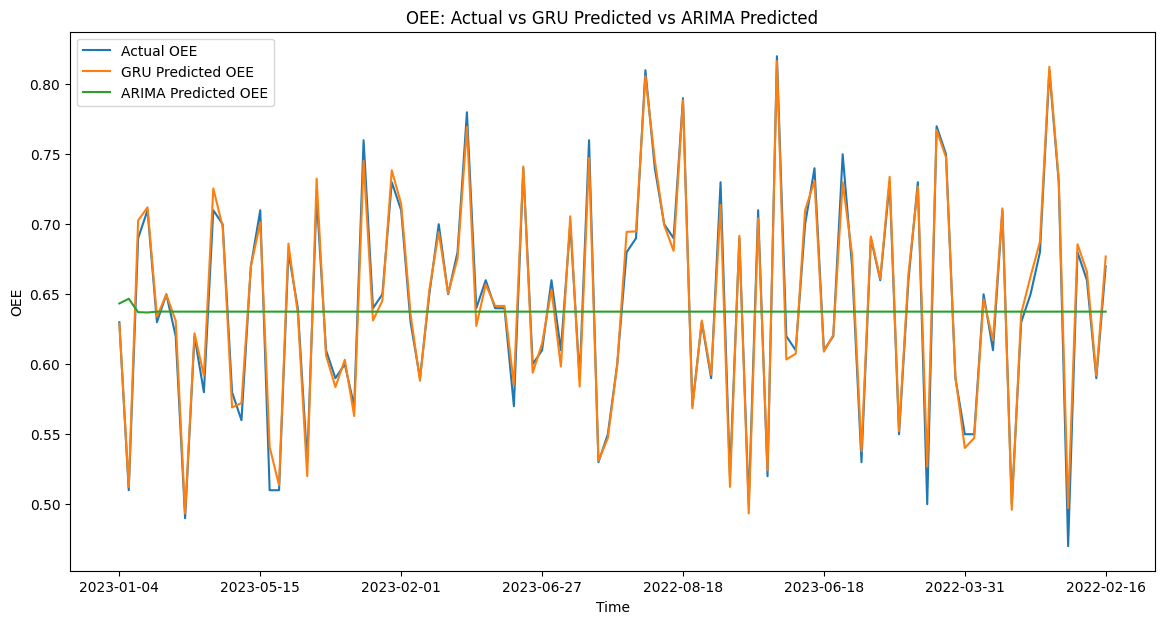

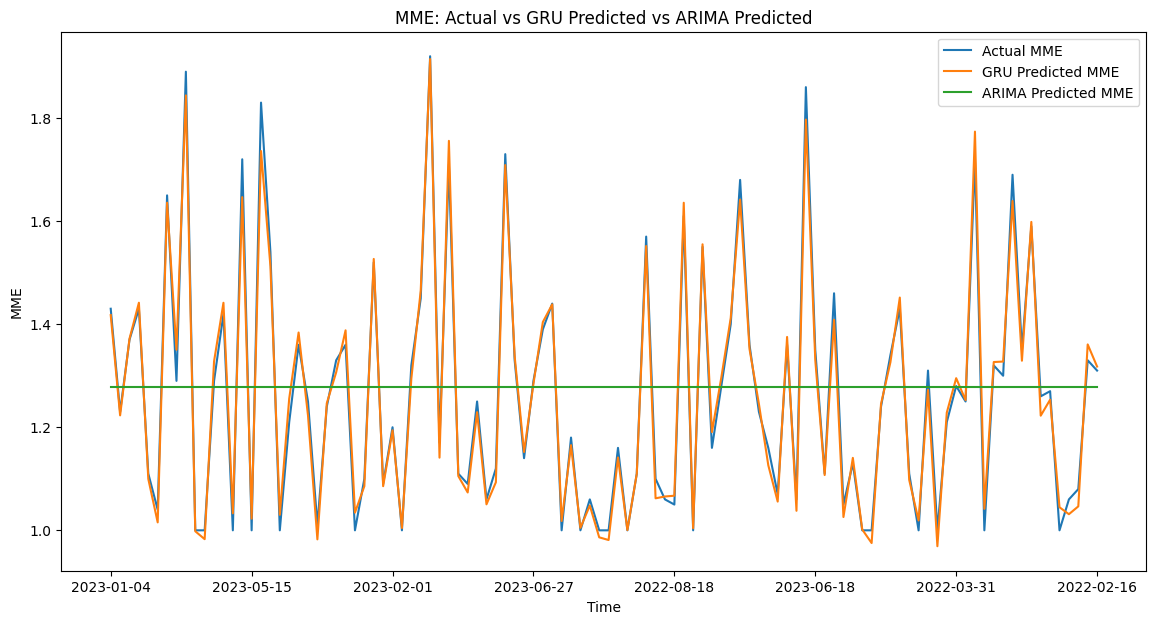

In [ ]:
# Adjust the lengths to ensure they match
min_length_oee = min(len(dates_test_seq), len(y_test_oee_inverse), len(y_pred_oee_inverse), len(oee_forecast))
min_length_mme = min(len(dates_test_seq), len(y_test_mme_inverse), len(y_pred_mme_inverse), len(mme_forecast))

dates_test_seq_oee = dates_test_seq[:min_length_oee]
y_test_oee_inverse = y_test_oee_inverse[:min_length_oee]
y_pred_oee_inverse = y_pred_oee_inverse[:min_length_oee]
oee_forecast = oee_forecast[:min_length_oee]

dates_test_seq_mme = dates_test_seq[:min_length_mme]
y_test_mme_inverse = y_test_mme_inverse[:min_length_mme]
y_pred_mme_inverse = y_pred_mme_inverse[:min_length_mme]
mme_forecast = mme_forecast[:min_length_mme]

# Plotting OEE: Actual vs GRU Predicted vs ARIMA Predicted
plt.figure(figsize=(14, 7))
plt.plot(dates_test_seq_oee, y_test_oee_inverse, label='Actual OEE')
plt.plot(dates_test_seq_oee, y_pred_oee_inverse, label='GRU Predicted OEE')
plt.plot(dates_test_seq_oee, oee_forecast, label='ARIMA Predicted OEE')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(8))
plt.title('OEE: Actual vs GRU Predicted vs ARIMA Predicted')
plt.xlabel('Time')
plt.ylabel('OEE')
plt.legend()

plt.show()

# Plotting MME: Actual vs GRU Predicted vs ARIMA Predicted
plt.figure(figsize=(14, 7))
plt.plot(dates_test_seq_mme, y_test_mme_inverse, label='Actual MME')
plt.plot(dates_test_seq_mme, y_pred_mme_inverse, label='GRU Predicted MME')
plt.plot(dates_test_seq_mme, mme_forecast, label='ARIMA Predicted MME')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(8))
plt.title('MME: Actual vs GRU Predicted vs ARIMA Predicted')
plt.xlabel('Time')
plt.ylabel('MME')
plt.legend()
plt.show()
